# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [162]:
import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import skew
import seaborn
from pySankey.sankey import sankey
from pandas.api.types import CategoricalDtype
from IPython.display import display, Markdown

In [163]:
# directories
checkDir = "../data/check/"
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

# create directories if they do not exist
directories = [checkDir, rawDir, interimDir, processedDir, imgDir]
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

def section_md(title):
    display(Markdown(f"### {title}"))

In [164]:
# Load the mapping from the Excel file
iso_df = pd.read_excel(rawDir + "iso_mapping.xlsx")
iso_mapping = dict(zip(iso_df['country'], iso_df['iso']))
country_mapping = dict(zip(iso_df['iso'], iso_df['country']))
print(list(country_mapping.keys())[:5])  # Show example keys
print(list(iso_mapping.values())[:5])  # Show example keys

# Other mappings
sovereign_iso = dict(zip(iso_df['country'], iso_df['sovereign']))
sovereign_country = dict(zip(iso_df['sovereign'], iso_df['sovereign_country']))
sovereign_iso_iso = dict(zip(iso_df['iso'], iso_df['sovereign']))

['ABW', 'AFG', 'AGO', 'AIA', 'ALA']
['ABW', 'AFG', 'AGO', 'AIA', 'ALA']


In [165]:
# Number of bootstrap iterations
n_draws = 100000

# 1. ELUC data

# 2. Sovereign data

## SLAND

In [166]:
df_sland_tmp = pd.read_csv(interimDir + "SLAND.csv")

In [167]:
# Group by country and iso to compute stats across all years/models
df_sland_stats = df_sland_tmp.groupby(["country", "iso"]).agg(
    Fa_mean=("SLAND", "mean"),
    Fa_std=("SLAND", "std"),
    Fa_skew=("SLAND", lambda x: skew(x, nan_policy="omit")),
    Fa_median=("SLAND", "median"),
    Fa_q17=("SLAND", lambda x: np.nanpercentile(x, 17)),
    Fa_q83=("SLAND", lambda x: np.nanpercentile(x, 83)),
    Fa_min=("SLAND", "min"),
    Fa_max=("SLAND", "max"),

    Fa_tf_mean=("SLAND_total_forest", "mean"),
    Fa_tf_std=("SLAND_total_forest", "std"),
    Fa_tf_skew=("SLAND_total_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_tf_median=("SLAND_total_forest", "median"),
    Fa_tf_q17=("SLAND_total_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_tf_q83=("SLAND_total_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_tf_min=("SLAND_total_forest", "min"),
    Fa_tf_max=("SLAND_total_forest", "max"),

    Fa_mf_mean=("SLAND_managed_forest", "mean"),
    Fa_mf_std=("SLAND_managed_forest", "std"),
    Fa_mf_skew=("SLAND_managed_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_mf_median=("SLAND_managed_forest", "median"),
    Fa_mf_q17=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_mf_q83=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_mf_min=("SLAND_managed_forest", "min"),
    Fa_mf_max=("SLAND_managed_forest", "max"),
).reset_index()

# Sort by ISO code
df_sland_stats = df_sland_stats.sort_values(by="iso").reset_index(drop=True)


In [168]:
# Replace iso codes with sovereign iso codes
df_sland_tmp["sovereign_iso"] = df_sland_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name
df_sland_tmp["sovereign_country"] = df_sland_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso, model, year — sum SLAND values
df_sland_sovereign = (
    df_sland_tmp
    .groupby(["sovereign_iso", "sovereign_country", "model", "year"], as_index=False)
    [["SLAND", "SLAND_total_forest", "SLAND_managed_forest"]]
    .sum()
)

# Rename for consistency
df_sland_sovereign = df_sland_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})

# Save the DataFrame 
#df_sland_sovereign.to_csv(interimDir + "SLAND_sovereign.csv", index=False)

In [169]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_sland_tmp["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print the mappings
if aggregated_isos:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")

Aggregated ISO columns:
ALA (Aland) ➝ FIN (Finland)
ATF (French Southern and Antarctic Lands) ➝ FRA (France)
BAY (Baykonur Cosmodrome) ➝ KAZ (Kazakhstan)
CYM (Cayman Islands) ➝ GBR (United Kingdom)
CYN (Northern Cyprus) ➝ CYP (Cyprus)
FLK (Falkland Islands) ➝ GBR (United Kingdom)
FRO (Faroe Islands) ➝ DNK (Denmark)
GRL (Greenland) ➝ DNK (Denmark)
HKG (Hong Kong S.A.R.) ➝ CHN (China)
NCL (New Caledonia) ➝ FRA (France)
PRI (Puerto Rico) ➝ USA (United States of America)
PYF (French Polynesia) ➝ FRA (France)
SGR (Siachen Glacier) ➝ IND (India)
SGS (South Georgia and the Islands) ➝ GBR (United Kingdom)
VIR (United States Virgin Islands) ➝ USA (United States of America)


### Statistics

In [170]:
# Group by country and iso to compute stats across all years/models
df_sland_sovereign_stats = df_sland_sovereign.groupby(["country", "iso"]).agg(
    Fa_mean=("SLAND", "mean"),
    Fa_std=("SLAND", "std"),
    Fa_skew=("SLAND", lambda x: skew(x, nan_policy="omit")),
    Fa_median=("SLAND", "median"),
    Fa_q17=("SLAND", lambda x: np.nanpercentile(x, 17)),
    Fa_q83=("SLAND", lambda x: np.nanpercentile(x, 83)),
    Fa_min=("SLAND", "min"),
    Fa_max=("SLAND", "max"),

    Fa_tf_mean=("SLAND_total_forest", "mean"),
    Fa_tf_std=("SLAND_total_forest", "std"),
    Fa_tf_skew=("SLAND_total_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_tf_median=("SLAND_total_forest", "median"),
    Fa_tf_q17=("SLAND_total_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_tf_q83=("SLAND_total_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_tf_min=("SLAND_total_forest", "min"),
    Fa_tf_max=("SLAND_total_forest", "max"),

    Fa_mf_mean=("SLAND_managed_forest", "mean"),
    Fa_mf_std=("SLAND_managed_forest", "std"),
    Fa_mf_skew=("SLAND_managed_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_mf_median=("SLAND_managed_forest", "median"),
    Fa_mf_q17=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_mf_q83=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_mf_min=("SLAND_managed_forest", "min"),
    Fa_mf_max=("SLAND_managed_forest", "max"),
).reset_index()

# Sort by ISO code
df_sland_sovereign_stats = df_sland_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Save to file
#df_sland_sovereign_stats.to_csv(interimDir + "SLAND_sovereign_stats.csv", index=False)


## ELUC

In [171]:
df_eluc_tmp = pd.read_csv(interimDir + "ELUC.csv")

In [172]:
# Group by country and ISO
df_eluc_stats = df_eluc_tmp.groupby(["country", "iso"]).agg(
    Fb_mean=("ELUC", "mean"),
    Fb_std=("ELUC", "std"),
    Fb_skew=("ELUC", lambda x: skew(x, nan_policy="omit")),
    Fb_median=("ELUC", "median"),
    Fb_q17=("ELUC", lambda x: np.nanpercentile(x, 17)),
    Fb_q83=("ELUC", lambda x: np.nanpercentile(x, 83)),
    Fb_min=("ELUC", "min"),
    Fb_max=("ELUC", "max"),
).reset_index()

# Sort by ISO code
df_eluc_stats = df_eluc_stats.sort_values(by="iso").reset_index(drop=True)

In [173]:
# Replace iso codes with sovereign iso codes
df_eluc_tmp["sovereign_iso"] = df_eluc_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name
df_eluc_tmp["sovereign_country"] = df_eluc_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso, model, year — sum SLAND values
df_eluc_sovereign = (
    df_eluc_tmp
    .groupby(["sovereign_iso", "sovereign_country", "model", "year"], as_index=False)
    [["ELUC"]]
    .sum()
)

# Rename for consistency
df_eluc_sovereign = df_eluc_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})

# Save the DataFrame 
#df_eluc_sovereign.to_csv(interimDir + "ELUC_sovereign.csv", index=False)

In [174]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos_eluc = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_eluc_tmp["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print
if aggregated_isos_eluc:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos_eluc.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")


Aggregated ISO columns:
NIU (Niue) ➝ NZL (New Zealand)


#### Statistics

In [175]:
# Group by country and ISO
df_eluc_sovereign_stats = df_eluc_sovereign.groupby(["country", "iso"]).agg(
    Fb_mean=("ELUC", "mean"),
    Fb_std=("ELUC", "std"),
    Fb_skew=("ELUC", lambda x: skew(x, nan_policy="omit")),
    Fb_median=("ELUC", "median"),
    Fb_q17=("ELUC", lambda x: np.nanpercentile(x, 17)),
    Fb_q83=("ELUC", lambda x: np.nanpercentile(x, 83)),
    Fb_min=("ELUC", "min"),
    Fb_max=("ELUC", "max"),
).reset_index()

# Sort by ISO code
df_eluc_sovereign_stats = df_eluc_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

print(df_eluc_sovereign_stats.head())

# Save to CSV and Excel
#df_eluc_sovereign_stats.to_csv(interimDir + "ELUC_sovereign_stats.csv", index=False)

                country  iso   Fb_mean    Fb_std   Fb_skew  Fb_median  \
0           Afghanistan  AFG  0.000815  0.000876  1.999402   0.000767   
1                Angola  AGO  0.026311  0.012415 -0.036353   0.028687   
2               Albania  ALB -0.000003  0.000159  0.679175  -0.000017   
3               Andorra  AND -0.000002  0.000001  0.082402  -0.000002   
4  United Arab Emirates  ARE -0.000105  0.000138 -1.173003  -0.000036   

     Fb_q17        Fb_q83    Fb_min        Fb_max  
0  0.000090  1.333341e-03 -0.000051  4.177120e-03  
1  0.013151  4.176428e-02  0.007125  4.391422e-02  
2 -0.000174  1.449499e-04 -0.000219  4.906700e-04  
3 -0.000003 -2.500000e-07 -0.000004  5.000000e-08  
4 -0.000335 -1.856170e-05 -0.000383 -6.910000e-06  


## EFOS

In [176]:
df_efos_tmp = pd.read_csv(interimDir + "EFOS.csv")

In [177]:
# Group by country and iso
grouped_efos = df_efos_tmp.groupby(["Country", "iso"])

# Compute the statistics
df_efos_stats = grouped_efos["EFOS"].agg(
    Fc_mean="mean",
    Fc_std="std",
    Fc_skew=lambda x: skew(x, nan_policy="omit"),
    Fc_median="median",
    Fc_q17=lambda x: np.nanpercentile(x, 17),
    Fc_q83=lambda x: np.nanpercentile(x, 83),
    Fc_min="min",
    Fc_max="max"
).reset_index()

# Sort by ISO code (optional)
df_efos_stats = df_efos_stats.sort_values(by="iso").reset_index(drop=True)

In [178]:
# Replace iso codes with sovereign iso codes
df_efos_tmp["sovereign_iso"] = df_efos_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name 
df_efos_tmp["sovereign_country"] = df_efos_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso and year — sum EFOS values
df_efos_sovereign = (
    df_efos_tmp
    .groupby(["sovereign_iso", "sovereign_country", "year"], as_index=False)
    [["EFOS"]]
    .sum()
)

# Rename for consistency
df_efos_sovereign = df_efos_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})

# Save the DataFrame
#df_efos_sovereign.to_csv(interimDir + "EFOS_sovereign.csv", index=False)


In [179]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos_efos = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_efos_tmp["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print 
if aggregated_isos_efos:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos_efos.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")


Aggregated ISO columns:
ABW (Aruba) ➝ NLD (Netherlands)
AIA (Anguilla) ➝ GBR (United Kingdom)
BES (Bonaire, Saint Eustatius and Saba) ➝ NLD (Netherlands)
BMU (Bermuda) ➝ GBR (United Kingdom)
CUW (Curaçao) ➝ NLD (Netherlands)
FRO (Faroe Islands) ➝ DNK (Denmark)
GRL (Greenland) ➝ DNK (Denmark)
HKG (Hong Kong S.A.R.) ➝ CHN (China)
MAC (Macao) ➝ CHN (China)
MSR (Montserrat) ➝ GBR (United Kingdom)
NCL (New Caledonia) ➝ FRA (France)
NIU (Niue) ➝ NZL (New Zealand)
PYF (French Polynesia) ➝ FRA (France)
SHN (Saint Helena) ➝ GBR (United Kingdom)
SPM (Saint Pierre and Miquelon) ➝ FRA (France)
SXM (Sint Maarten (Dutch part)) ➝ NLD (Netherlands)
TCA (Turks and Caicos Islands) ➝ GBR (United Kingdom)
VGB (British Virgin Islands) ➝ GBR (United Kingdom)
WLF (Wallis and Futuna Islands) ➝ FRA (France)


#### Statistics

In [180]:
# Group by country and iso
grouped_efos = df_efos_sovereign.groupby(["country", "iso"])

# Compute the statistics
df_efos_sovereign_stats = grouped_efos["EFOS"].agg(
    Fc_mean="mean",
    Fc_std="std",
    Fc_skew=lambda x: skew(x, nan_policy="omit"),
    Fc_median="median",
    Fc_q17=lambda x: np.nanpercentile(x, 17),
    Fc_q83=lambda x: np.nanpercentile(x, 83),
    Fc_min="min",
    Fc_max="max"
).reset_index()

# Sort by ISO code (optional)
df_efos_sovereign_stats = df_efos_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Show result
print(df_efos_sovereign_stats.head())

#df_efos_sovereign_stats.to_csv(interimDir + "EFOS_sovereign_stats.csv", index=False)

                country  iso   Fc_mean    Fc_std   Fc_skew  Fc_median  \
0           Afghanistan  AFG  0.002820  0.000280  0.082846   0.002823   
1                Angola  AGO  0.004457  0.000520  0.327170   0.004352   
2               Albania  ALB  0.001374  0.000110  1.342737   0.001342   
3               Andorra  AND  0.000123  0.000010 -0.964030   0.000127   
4  United Arab Emirates  ARE  0.058987  0.001852  0.187055   0.058869   

     Fc_q17    Fc_q83    Fc_min    Fc_max  
0  0.002514  0.003070  0.002475  0.003245  
1  0.004114  0.004965  0.003619  0.005396  
2  0.001297  0.001439  0.001253  0.001634  
3  0.000113  0.000131  0.000102  0.000135  
4  0.057234  0.061252  0.056612  0.061446  


## CSCC

In [188]:
df_cscc_tmp = pd.read_csv(interimDir + "CSCC.csv")

In [189]:
# Rename columns using the sovereign mapping
df_cscc_renamed = df_cscc_tmp.rename(columns=sovereign_iso_iso)

# Original and renamed columns
original_columns = df_cscc_tmp.columns
renamed_columns = df_cscc_renamed.columns

# Compare and print changes
renamed = {
    orig: sovereign_iso_iso[orig]
    for orig in original_columns
    if orig in sovereign_iso_iso and sovereign_iso_iso[orig] != orig
}

print("Renamed columns:")
for orig, new in renamed.items():
    print(f"{orig} ➝ {new}")


Renamed columns:
NCL ➝ FRA


In [ ]:
# Group by column names (sovereign ISO) and sum
df_cscc_sovereign = df_cscc_renamed.T.groupby(level=0).sum().T

# Save filled version
#df_cscc_sovereign.to_csv(interimDir + "CSCC_sovereign.csv", index=False)

print("New shape:", df_cscc_sovereign.shape)

New shape: (210000, 169)


##### Statistics

In [191]:
# Calculate statistics 
df_cscc_sovereign_stats = pd.DataFrame({
    "iso": df_cscc_sovereign.columns,
    "CSCC_mean": df_cscc_sovereign.mean().values,
    "CSCC_std": df_cscc_sovereign.std().values,
    "CSCC_skew": df_cscc_sovereign.apply(skew),  
    "CSCC_median": df_cscc_sovereign.median().values,
    "CSCC_q17": df_cscc_sovereign.quantile(0.17).values,
    "CSCC_q83": df_cscc_sovereign.quantile(0.83).values,
    "CSCC_min": df_cscc_sovereign.min().values,
    "CSCC_max": df_cscc_sovereign.max().values,
})

# Add country names 
df_cscc_sovereign_stats["Country"] = df_cscc_sovereign_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_sovereign_stats.columns if col not in ["Country", "iso"]]
df_cscc_sovereign_stats = df_cscc_sovereign_stats[cols]

# Sort by ISO
df_cscc_sovereign_stats = df_cscc_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_sovereign_stats.head())

# Save to CSV
df_cscc_sovereign_stats.to_csv(processedDir + "CSCC_sovereign_stats.csv", index=False)

                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.270706  0.524324   0.334824     0.248449   
1                Angola  AGO   0.784811  0.486604   0.429781     0.750965   
2               Albania  ALB   0.015833  0.027773   0.444808     0.014326   
3  United Arab Emirates  ARE   2.068121  1.129388   0.412237     1.986328   
4             Argentina  ARG   0.939210  0.902089   0.765869     0.828589   

   CSCC_q17  CSCC_q83  CSCC_min  CSCC_max  
0 -0.232361  0.744819 -1.924873  3.317865  
1  0.335901  1.228723 -0.869293  3.557607  
2 -0.010694  0.040551 -0.100694  0.207697  
3  1.044161  3.099035 -1.859206  8.551064  
4  0.120100  1.743461 -2.202527  7.230914  


## All vs. Sovereign Statistics

In [181]:
def compute_deltas(df_all, df_sovereign, threshold=1e-15):
    df_diff = df_sovereign.set_index("iso").copy()
    df_all = df_all.set_index("iso")
    
    # Ensure matching index
    df_diff = df_diff.loc[df_diff.index.intersection(df_all.index)]
    df_all = df_all.loc[df_diff.index]

    # Compute deltas with threshold applied
    delta_cols = {}
    for col in df_all.columns:
        if col in df_diff.columns and col not in ["country"]:
            raw_delta = df_diff[col] - df_all[col]
            delta_cols[col] = np.where(np.abs(raw_delta) < threshold, 0.0, raw_delta)
    
    # Combine results into a DataFrame
    df_result = pd.DataFrame(delta_cols, index=df_diff.index)
    df_result["country"] = df_sovereign.set_index("iso").loc[df_result.index]["country"]
    df_result = df_result.reset_index()
    
    return df_result

In [182]:
df_sland_all_sov = compute_deltas(df_sland_stats, df_sland_sovereign_stats)
df_eluc_all_sov = compute_deltas(df_eluc_stats, df_eluc_sovereign_stats)
df_efos_all_sov = compute_deltas(df_efos_stats, df_efos_sovereign_stats)

In [183]:
print(df_sland_all_sov.columns)
section_md("SLAND difference between all and sovereign countries")
# print top 10 countries by Fa_mean
top_sov = df_sland_all_sov.loc[df_sland_all_sov["iso"] != "Total", ["iso", "Fa_mean"]].sort_values("Fa_mean", ascending=True).head(3).reset_index(drop=True)
display(top_sov.style.format({"Fa_mean": "{:.5f}"}))

section_md("Oversea contributions to sland for Denmark")
# Get ISO codes of Denmark's overseas territories
overseas_isos = df_sland_tmp[
    (df_sland_tmp["sovereign_iso"] == "DNK") & (df_sland_tmp["iso"] != "DNK")
]["iso"].unique()

# Filter stats table for those ISO codes
df_denmark_overseas_stats = df_sland_stats[df_sland_stats["iso"].isin(overseas_isos)]
# filter relevant columns Fa_mean and Fa_tf_mean
df_denmark_overseas_stats = df_denmark_overseas_stats[["iso", "Fa_mean", "Fa_tf_mean"]]

# display without rounding
display(df_denmark_overseas_stats)

section_md("Top 2 Countries by Sovereign Land Sink for totalcurrent forest cover")
top_sov = df_sland_all_sov.loc[df_sland_all_sov["iso"] != "Total", ["iso", "Fa_tf_mean"]].sort_values("Fa_tf_mean", ascending=True).head(2).reset_index(drop=True)
display(top_sov.style.format({"Fa_tf_mean": "{:.5f}"}))


Index(['iso', 'Fa_mean', 'Fa_std', 'Fa_skew', 'Fa_median', 'Fa_q17', 'Fa_q83',
       'Fa_min', 'Fa_max', 'Fa_tf_mean', 'Fa_tf_std', 'Fa_tf_skew',
       'Fa_tf_median', 'Fa_tf_q17', 'Fa_tf_q83', 'Fa_tf_min', 'Fa_tf_max',
       'Fa_mf_mean', 'Fa_mf_std', 'Fa_mf_skew', 'Fa_mf_median', 'Fa_mf_q17',
       'Fa_mf_q83', 'Fa_mf_min', 'Fa_mf_max', 'country'],
      dtype='object')


### SLAND difference between all and sovereign countries

,iso,Fa_mean
0,DNK,-0.00056
1,USA,-0.00051
2,FRA,-0.00037


### Oversea contributions to sland for Denmark

,iso,Fa_mean,Fa_tf_mean
64,FRO,-0.000004,0.0
74,GRL,-0.000560,0.0


### Top 2 Countries by Sovereign Land Sink for totalcurrent forest cover

,iso,Fa_tf_mean
0,USA,-0.00037
1,FRA,-0.00019


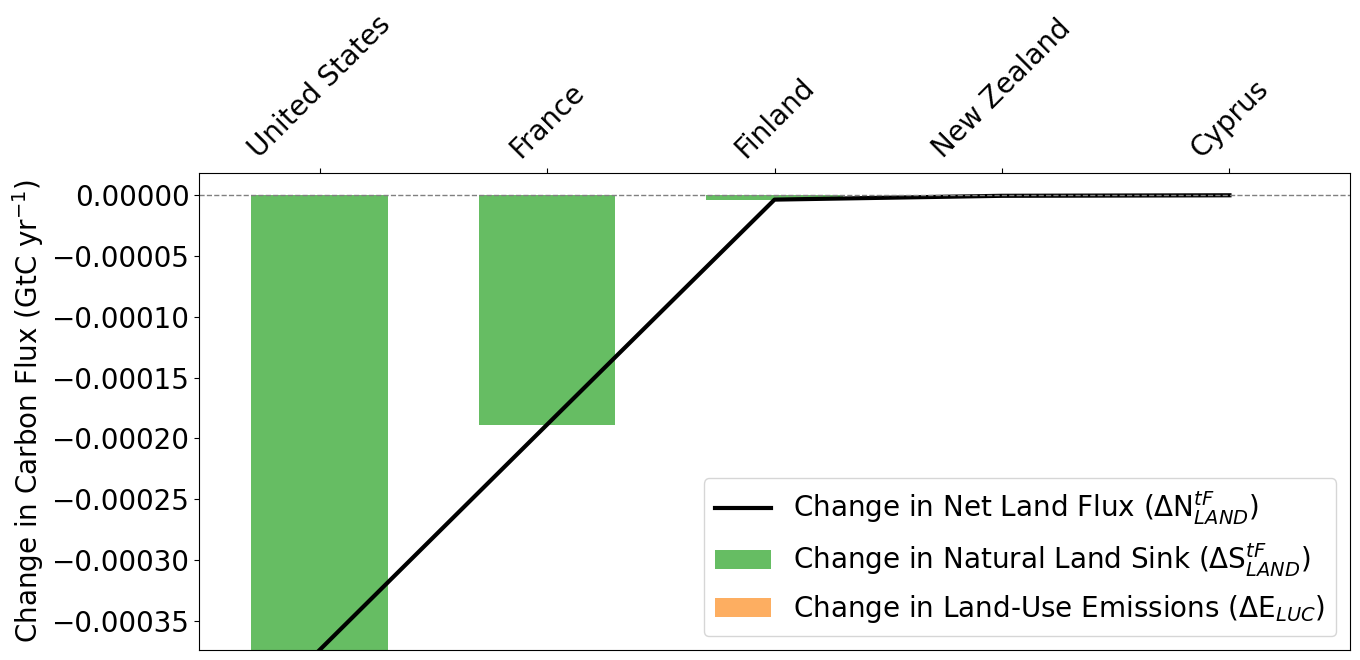

In [184]:
# Merge deltas into one DataFrame
df_deltas = df_sland_all_sov[["iso", "country", "Fa_mean", "Fa_tf_mean"]].merge(
    df_eluc_all_sov[["iso", "Fb_mean"]], on="iso")

# Filter to countries where at least one value is not zero
df_deltas = df_deltas[
    (df_deltas["Fa_tf_mean"] != 0) |
    (df_deltas["Fb_mean"] != 0)
].reset_index(drop=True)



# Compute fab and fabc before sorting
df_deltas["fab_tf_values"] = df_deltas["Fa_tf_mean"] + df_deltas["Fb_mean"]

# Sort by fab_values
df_deltas = df_deltas.sort_values("fab_tf_values", ascending=True).reset_index(drop=True)

# Update country names for specific ISO codes
df_deltas.loc[df_deltas["iso"] == "USA", "country"] = "United States"

# Extract plotting data
countries = df_deltas["country"]
sland_values = df_deltas["Fa_tf_mean"]
eluc_values = df_deltas["Fb_mean"]
fab_values = df_deltas["fab_tf_values"] 

# Set global font size
plt.rcParams.update({"font.size": 20})

# Bar chart settings
fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.6
x = np.arange(len(countries))

positive_stack = np.zeros(len(countries))
negative_stack = np.zeros(len(countries))

# Loop through and add bars with error bars
for i in range(len(countries)):
    # SLAND
    ax.bar(
        x[i],
        sland_values.iloc[i],
        width=bar_width,
        color="#66bd63",
        bottom=positive_stack[i] if sland_values.iloc[i] > 0 else negative_stack[i],
        #yerr=[[sland_err[0].iloc[i]], [sland_err[1].iloc[i]]],
        capsize=4,
        label=r"Change in Natural Land Sink (ΔS$^{tF}_{LAND}$)" if i == 0 else ""
    )
    (positive_stack if sland_values.iloc[i] > 0 else negative_stack)[i] += sland_values.iloc[i]

    # ELUC
    ax.bar(
        x[i],
        eluc_values.iloc[i],
        width=bar_width,
        color="#fdae61",
        bottom=positive_stack[i] if eluc_values.iloc[i] > 0 else negative_stack[i],
        #yerr=[[eluc_err[0].iloc[i]], [eluc_err[1].iloc[i]]],
        capsize=4,
        label=r"Change in Land-Use Emissions (ΔE$_{LUC}$)" if i == 0 else ""
    )
    (positive_stack if eluc_values.iloc[i] > 0 else negative_stack)[i] += eluc_values.iloc[i]



# Add Fab/Fabc lines
ax.plot(x, fab_values, color="black", linestyle="-", linewidth=3,
        label=r"Change in Net Land Flux (ΔN$^{tF}_{LAND}$)")

# Format
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, fontsize=20)
ax.set_ylabel(r"Change in Carbon Flux (GtC yr$^{-1}$)")
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

ax.legend()
plt.tight_layout()
plt.savefig(imgDir + "figure_8_SI.jpg", format="jpg")
plt.show()


## Figure 9 SI (SLAND)

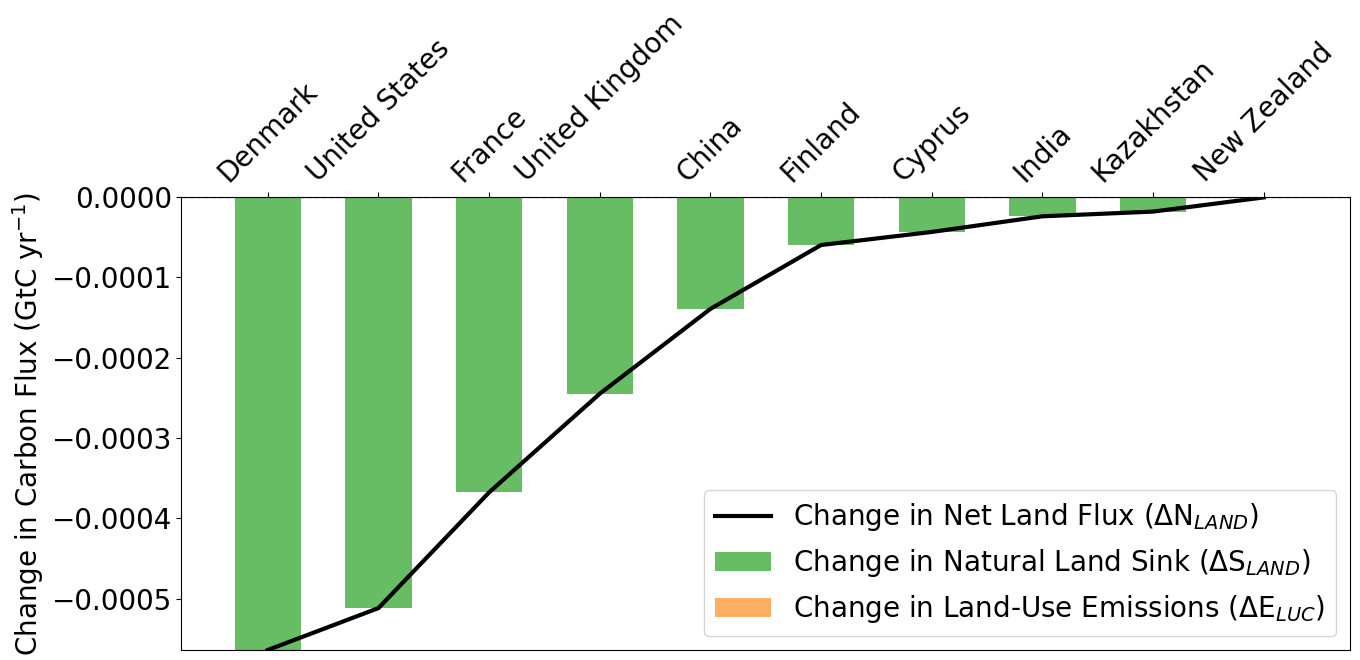

In [185]:
# Merge deltas into one DataFrame
df_deltas = df_sland_all_sov[["iso", "country", "Fa_mean", "Fa_tf_mean"]].merge(
    df_eluc_all_sov[["iso", "Fb_mean"]], on="iso")

# Filter to countries where at least one value is not zero
df_deltas = df_deltas[
    (df_deltas["Fa_mean"] != 0) |
    (df_deltas["Fb_mean"] != 0) 
].reset_index(drop=True)

# Compute fab and fabc before sorting
df_deltas["fab_values"] = df_deltas["Fa_mean"] + df_deltas["Fb_mean"]

# Sort by fab_values
df_deltas = df_deltas.sort_values("fab_values", ascending=True).reset_index(drop=True)

# Update country names for specific ISO codes
df_deltas.loc[df_deltas["iso"] == "USA", "country"] = "United States"

# Extract plotting data
countries = df_deltas["country"]
sland_values = df_deltas["Fa_mean"] 
eluc_values = df_deltas["Fb_mean"]  
fab_values = df_deltas["fab_values"] 

# Set global font size
plt.rcParams.update({"font.size": 20})

# Bar chart settings
fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.6
x = np.arange(len(countries))

positive_stack = np.zeros(len(countries))
negative_stack = np.zeros(len(countries))

# Loop through and add bars with error bars
for i in range(len(countries)):
    # SLAND
    ax.bar(
        x[i],
        sland_values.iloc[i],
        width=bar_width,
        color="#66bd63",
        bottom=positive_stack[i] if sland_values.iloc[i] > 0 else negative_stack[i],
        #yerr=[[sland_err[0].iloc[i]], [sland_err[1].iloc[i]]],
        capsize=4,
        label=r"Change in Natural Land Sink (ΔS$_{LAND}$)" if i == 0 else ""
    )
    (positive_stack if sland_values.iloc[i] > 0 else negative_stack)[i] += sland_values.iloc[i]

    # ELUC
    ax.bar(
        x[i],
        eluc_values.iloc[i],
        width=bar_width,
        color="#fdae61",
        bottom=positive_stack[i] if eluc_values.iloc[i] > 0 else negative_stack[i],
        #yerr=[[eluc_err[0].iloc[i]], [eluc_err[1].iloc[i]]],
        capsize=4,
        label=r"Change in Land-Use Emissions (ΔE$_{LUC}$)" if i == 0 else ""
    )
    (positive_stack if eluc_values.iloc[i] > 0 else negative_stack)[i] += eluc_values.iloc[i]

# Add Fab/Fabc lines
ax.plot(x, fab_values, color="black", linestyle="-", linewidth=3,
        label=r"Change in Net Land Flux (ΔN$_{LAND}$)")

# Format
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, fontsize=20)
ax.set_ylabel(r"Change in Carbon Flux (GtC yr$^{-1}$)")
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

ax.legend()
plt.tight_layout()
plt.savefig(imgDir + "figure_9_SI.jpg", format="jpg")
plt.show()


# 3. CSCC

In [132]:
# CSCC Data Import
cscc_df = pd.read_csv(
    rawDir + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

cscc_raw_estimates = pd.read_csv(
    rawDir + "raw_scc_SSP2_rcp60_constant_estimates_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

cscc_boots = pd.read_csv(
    rawDir + "raw_scc_SSP2_rcp60_constant_bootstrap_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

In [133]:
# Load the CSV file into a pandas DataFrame
GDP_df = pd.read_csv(rawDir + 'Worldbank_Deflator.csv')
# Extract the values for 2005 and 2020
gdp_2005 = GDP_df.loc[0, '2005']  # Access the 2005 value from the first row
gdp_2020 = GDP_df.loc[0, '2020']  # Access the 2020 value from the first row
print(gdp_2005)
print(gdp_2020)
print(gdp_2020 / gdp_2005)

83.8058099105923
108.266880351916
1.2918779791928487


### Ignoring NAs

Using the boots dataframe
2020 USD in tCO2 without WLD 


In [134]:
# Select columns that contain "2p5" but do not contain "WLD"
selected_columns = [col for col in cscc_boots.columns if "1p5" in col and "WLD" not in col]

# Create the new dataframe with selected columns
df_cscc_NA = cscc_boots[selected_columns].copy()

# Rename columns using the last 3 characters of each column name
df_cscc_NA.columns = [col[-3:] for col in df_cscc_NA.columns]

# Perform unit conversion
conversion = (gdp_2020 / gdp_2005) 
df_cscc_NA *= conversion

##### Statistics

In [135]:
# Add a "Total" column that sums across all columns 
df_cscc_NA["Total"] = df_cscc_NA.sum(axis=1)

# Calculate each stat for all columns (columns are ISO codes)
df_cscc_NA_stats = pd.DataFrame({
    "iso": df_cscc_NA.columns,
    "CSCC_mean": df_cscc_NA.mean(skipna=True).values,
    "CSCC_std": df_cscc_NA.std(skipna=True).values,
    "CSCC_skew": df_cscc_NA.apply(lambda x: skew(x, nan_policy="omit")),
    "CSCC_median": df_cscc_NA.median(skipna=True).values,
    "CSCC_q17": df_cscc_NA.quantile(0.17).values,
    "CSCC_q83": df_cscc_NA.quantile(0.83).values,
    "CSCC_min": df_cscc_NA.min(skipna=True).values,
    "CSCC_max": df_cscc_NA.max(skipna=True).values,
})


# Add country names using your iso_mapping dictionary
df_cscc_NA_stats["Country"] = df_cscc_NA_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_NA_stats.columns if col not in ["Country", "iso"]]
df_cscc_NA_stats = df_cscc_NA_stats[cols]

# Sort by ISO 
df_cscc_NA_stats = df_cscc_NA_stats.sort_values(by="iso").reset_index(drop=True)


### Bootstrapping NAs

In [136]:
# Define target row count
target_rows = 210_000

np.random.seed(41) 

df_cscc = df_cscc_NA.drop(columns="Total", errors="ignore").copy()

# Fill missing values by sampling from non-NA values per column
for col in df_cscc.columns:
    current_values = df_cscc[col].dropna().values
    current_count = len(current_values)
    
    if current_count < target_rows:
        missing_count = target_rows - current_count
        
        if current_count == 0:
            print(f"Column '{col}' has no values to sample from — skipping.")
            continue
        
        # Sample from existing values with replacement
        fill_values = np.random.choice(current_values, size=missing_count, replace=True)
        
        # Find indices where NaN
        nan_indices = df_cscc[col].index[df_cscc[col].isna()]
        
        # Fill NaNs with sampled values
        df_cscc.loc[nan_indices, col] = fill_values

df_cscc["Total"] = df_cscc.sum(axis=1)

# Final shape check
assert df_cscc.shape[0] == 210_000
assert df_cscc.isna().sum().sum() == 0  # No NAs left


##### Statistics

In [137]:
# Calculate statistics
df_cscc_stats = pd.DataFrame({
    "iso": df_cscc.columns,
    "CSCC_mean": df_cscc.mean().values,
    "CSCC_std": df_cscc.std().values,
    "CSCC_skew": df_cscc.apply(skew),  
    "CSCC_median": df_cscc.median().values,
    "CSCC_q17": df_cscc.quantile(0.17).values,
    "CSCC_q025": df_cscc.quantile(0.025).values,
    "CSCC_q975": df_cscc.quantile(0.975).values,
    "CSCC_q83": df_cscc.quantile(0.83).values,
    "CSCC_min": df_cscc.min().values,
    "CSCC_max": df_cscc.max().values,
})

# Add country names
df_cscc_stats["Country"] = df_cscc_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_stats.columns if col not in ["Country", "iso"]]
df_cscc_stats = df_cscc_stats[cols]

# Sort by ISO
df_cscc_stats = df_cscc_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_stats.head())

# print total row
total_row = df_cscc_stats[df_cscc_stats["iso"] == "Total"]
print(total_row)


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008595  0.035187   0.454782     0.006835   
1                Angola  AGO   0.315399  0.217100   0.844573     0.290220   
2               Albania  ALB   0.004956  0.010105   0.625648     0.004197   
3  United Arab Emirates  ARE   1.490914  0.980130   1.219690     1.335772   
4             Argentina  ARG   0.328544  0.331038   0.943650     0.282399   

   CSCC_q17  CSCC_q025  CSCC_q975  CSCC_q83  CSCC_min   CSCC_max  
0 -0.025535  -0.052273   0.084259  0.040633 -0.125585   0.245872  
1  0.118612  -0.046666   0.825101  0.504470 -0.274041   1.948007  
2 -0.004687  -0.012112   0.027414  0.013823 -0.033453   0.087136  
3  0.646974  -0.036208   3.900834  2.300081 -0.950749  10.044391  
4  0.029580  -0.196227   1.123383  0.616115 -0.695154   2.973632  
           Country    iso  CSCC_mean   CSCC_std  CSCC_skew  CSCC_median  \
155  All Countries  Total  35.388533  42.784187   0.631949  

#### Sovereign

In [138]:
# Rename columns using the sovereign mapping
df_cscc_renamed = df_cscc.rename(columns=sovereign_iso_iso)

# Original and renamed columns
original_columns = df_cscc.columns
renamed_columns = df_cscc_renamed.columns

# Compare and print changes
renamed = {
    orig: sovereign_iso_iso[orig]
    for orig in original_columns
    if orig in sovereign_iso_iso and sovereign_iso_iso[orig] != orig
}

print("Renamed columns:")
for orig, new in renamed.items():
    print(f"{orig} ➝ {new}")


Renamed columns:
NCL ➝ FRA


In [139]:
# Group by column names (sovereign ISO) and sum
df_cscc_sovereign = df_cscc_renamed.T.groupby(level=0).sum().T



print("New shape:", df_cscc_sovereign.shape)

New shape: (210000, 169)


##### Statistics

In [140]:
# Calculate statistics 
df_cscc_sovereign_stats = pd.DataFrame({
    "iso": df_cscc_sovereign.columns,
    "CSCC_mean": df_cscc_sovereign.mean().values,
    "CSCC_std": df_cscc_sovereign.std().values,
    "CSCC_skew": df_cscc_sovereign.apply(skew),  
    "CSCC_median": df_cscc_sovereign.median().values,
    "CSCC_q17": df_cscc_sovereign.quantile(0.17).values,
    "CSCC_q83": df_cscc_sovereign.quantile(0.83).values,
    "CSCC_min": df_cscc_sovereign.min().values,
    "CSCC_max": df_cscc_sovereign.max().values,
})

# Add country names 
df_cscc_sovereign_stats["Country"] = df_cscc_sovereign_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_sovereign_stats.columns if col not in ["Country", "iso"]]
df_cscc_sovereign_stats = df_cscc_sovereign_stats[cols]

# Sort by ISO
df_cscc_sovereign_stats = df_cscc_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_sovereign_stats.head())


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008595  0.035187   0.454782     0.006835   
1                Angola  AGO   0.315399  0.217100   0.844573     0.290220   
2               Albania  ALB   0.004956  0.010105   0.625648     0.004197   
3  United Arab Emirates  ARE   1.490914  0.980130   1.219690     1.335772   
4             Argentina  ARG   0.328544  0.331038   0.943650     0.282399   

   CSCC_q17  CSCC_q83  CSCC_min   CSCC_max  
0 -0.025535  0.040633 -0.125585   0.245872  
1  0.118612  0.504470 -0.274041   1.948007  
2 -0.004687  0.013823 -0.033453   0.087136  
3  0.646974  2.300081 -0.950749  10.044391  
4  0.029580  0.616115 -0.695154   2.973632  


### Bootstrapping whole dataset bn = 100000

In [141]:
# Copy
df_cscc_boot = df_cscc.copy()

# Perform row-wise bootstrap
df_cscc_boot = df_cscc_boot.sample(n=n_draws, replace=True, random_state=38) # cscc 38!

# Reset index
df_cscc_boot.reset_index(drop=True, inplace=True)

##### Statistics

In [142]:
# Calculate statistics
df_cscc_boot_stats = pd.DataFrame({
    "iso": df_cscc_boot.columns,
    "CSCC_mean": df_cscc_boot.mean().values,
    "CSCC_std": df_cscc_boot.std().values,
    "CSCC_skew": df_cscc_boot.apply(skew),  
    "CSCC_median": df_cscc_boot.median().values,
    "CSCC_q17": df_cscc_boot.quantile(0.17).values,
    "CSCC_q83": df_cscc_boot.quantile(0.83).values,
    "CSCC_min": df_cscc_boot.min().values,
    "CSCC_max": df_cscc_boot.max().values,
})

# Add country names
df_cscc_boot_stats["Country"] = df_cscc_boot_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_boot_stats.columns if col not in ["Country", "iso"]]
df_cscc_boot_stats = df_cscc_boot_stats[cols]

# Sort by ISO
df_cscc_boot_stats = df_cscc_boot_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_boot_stats.head())

# print total row
total_row_boot = df_cscc_boot_stats[df_cscc_boot_stats["iso"] == "Total"]
print(total_row_boot)


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008620  0.035049   0.444686     0.007045   
1                Angola  AGO   0.315587  0.216650   0.854030     0.290493   
2               Albania  ALB   0.004956  0.010056   0.613957     0.004262   
3  United Arab Emirates  ARE   1.490737  0.976545   1.233521     1.337450   
4             Argentina  ARG   0.328864  0.330006   0.940479     0.283692   

   CSCC_q17  CSCC_q83  CSCC_min  CSCC_max  
0 -0.025321  0.040605 -0.125585  0.245872  
1  0.119090  0.503707 -0.258563  1.948007  
2 -0.004657  0.013818 -0.032200  0.087136  
3  0.650209  2.299051 -0.937331  9.621076  
4  0.030266  0.615545 -0.695154  2.973632  
           Country    iso  CSCC_mean   CSCC_std  CSCC_skew  CSCC_median  \
155  All Countries  Total  35.416094  42.641128   0.627487    32.282001   

     CSCC_q17   CSCC_q83   CSCC_min    CSCC_max  
155 -5.661429  73.138803 -99.246235  355.403902  


##### Shadow prices

In [143]:
df_g = df_cscc_boot * 3.664 * -1 # Convert to GtC and invert sign


###### Statistics

In [144]:
# Calculate statistics
df_g_stats = pd.DataFrame({
    "iso": df_g.columns,
    "g_mean": df_g.mean().values,
    "g_std": df_g.std().values,
    "g_skew": df_g.apply(skew),  
    "g_median": df_g.median().values,
    "g_q17": df_g.quantile(0.17).values,
    "g_q83": df_g.quantile(0.83).values,
    "g_min": df_g.min().values,
    "g_max": df_g.max().values,
})

# Add country names 
df_g_stats["Country"] = df_g_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_g_stats.columns if col not in ["Country", "iso"]]
df_g_stats = df_g_stats[cols]

# Sort by ISO 
df_g_stats = df_g_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_g_stats.head())

# print total row
total_row_g = df_g_stats[df_g_stats["iso"] == "Total"]
print(total_row_g)


                Country  iso    g_mean     g_std    g_skew  g_median  \
0           Afghanistan  AFG -0.031584  0.128420 -0.444686 -0.025815   
1                Angola  AGO -1.156310  0.793806 -0.854030 -1.064367   
2               Albania  ALB -0.018159  0.036845 -0.613957 -0.015614   
3  United Arab Emirates  ARE -5.462060  3.578061 -1.233521 -4.900418   
4             Argentina  ARG -1.204956  1.209141 -0.940479 -1.039449   

      g_q17     g_q83      g_min     g_max  
0 -0.148778  0.092774  -0.900875  0.460143  
1 -1.845584 -0.436347  -7.137497  0.947374  
2 -0.050630  0.017061  -0.319266  0.117981  
3 -8.423723 -2.382366 -35.251623  3.434380  
4 -2.255358 -0.110895 -10.895386  2.547044  
           Country    iso      g_mean       g_std    g_skew    g_median  \
155  All Countries  Total -129.764569  156.237093 -0.627487 -118.281252   

          g_q17      g_q83        g_min       g_max  
155 -267.980575  20.743476 -1302.199897  363.638204  


###### Without country i

In [145]:
# Exclude 'Total' column if it exists
df_input = df_g.drop(columns=["Total"], errors="ignore")

# Compute total per row (sum across all countries)
row_totals = df_input.sum(axis=1)  # Series of shape (210000,)

# Subtract each column from the row total and store in a dict
residual_data = {
    col: row_totals - df_input[col] for col in df_input.columns
}

# Combine all columns into a new DataFrame
df_g_minus = pd.concat(residual_data, axis=1)


In [146]:
df_sland_boot      = pd.read_csv(interimDir + "SLAND_boot.csv")
df_sland_tf_boot   = pd.read_csv(interimDir + "SLAND_tf_boot.csv")
df_sland_mf_boot   = pd.read_csv(interimDir + "SLAND_mf_boot.csv")
df_eluc_boot       = pd.read_csv(interimDir + "ELUC_boot.csv")
df_efos_boot       = pd.read_csv(interimDir + "EFOS_boot.csv")
df_Fab             = pd.read_csv(interimDir + "Fab.csv")
df_Fab_tf          = pd.read_csv(interimDir + "Fab_tf.csv")
df_Fab_mf          = pd.read_csv(interimDir + "Fab_mf.csv")
df_Fbc             = pd.read_csv(interimDir + "Fbc.csv")
df_Fabc            = pd.read_csv(interimDir + "Fabc.csv")
df_Fabc_tf         = pd.read_csv(interimDir + "Fabc_tf.csv")
df_Fabc_mf         = pd.read_csv(interimDir + "Fabc_mf.csv")

In [147]:
df_sland_boot_minus      = pd.read_csv(interimDir + "SLAND_boot_minus.csv")
df_sland_tf_boot_minus   = pd.read_csv(interimDir + "SLAND_tf_boot_minus.csv")
df_sland_mf_boot_minus   = pd.read_csv(interimDir + "SLAND_mf_boot_minus.csv")
df_eluc_boot_minus       = pd.read_csv(interimDir + "ELUC_boot_minus.csv")
df_efos_boot_minus       = pd.read_csv(interimDir + "EFOS_boot_minus.csv")
df_Fab_minus             = pd.read_csv(interimDir + "Fab_minus.csv")
df_Fab_tf_minus          = pd.read_csv(interimDir + "Fab_tf_minus.csv")
df_Fab_mf_minus          = pd.read_csv(interimDir + "Fab_mf_minus.csv")
df_Fbc_minus             = pd.read_csv(interimDir + "Fbc_minus.csv")
df_Fabc_minus            = pd.read_csv(interimDir + "Fabc_minus.csv")
df_Fabc_tf_minus         = pd.read_csv(interimDir + "Fabc_tf_minus.csv")
df_Fabc_mf_minus         = pd.read_csv(interimDir + "Fabc_mf_minus.csv")

In [148]:
df_sland_boot_stats     = pd.read_csv(processedDir + "SLAND_boot_stats.csv")
df_sland_mf_boot_stats  = pd.read_csv(processedDir + "SLAND_mf_boot_stats.csv")
df_sland_tf_boot_stats  = pd.read_csv(processedDir + "SLAND_tf_boot_stats.csv")
df_eluc_boot_stats      = pd.read_csv(processedDir + "ELUC_boot_stats.csv")
df_efos_boot_stats      = pd.read_csv(processedDir + "EFOS_boot_stats.csv")
df_Fab_stats            = pd.read_csv(processedDir + "Fab_stats.csv")
df_Fab_mf_stats         = pd.read_csv(processedDir + "Fab_mf_stats.csv")
df_Fab_tf_stats         = pd.read_csv(processedDir + "Fab_tf_stats.csv")
df_Fbc_stats            = pd.read_csv(processedDir + "Fbc_stats.csv")
df_Fabc_stats           = pd.read_csv(processedDir + "Fabc_stats.csv")
df_Fabc_mf_stats        = pd.read_csv(processedDir + "Fabc_mf_stats.csv")
df_Fabc_tf_stats        = pd.read_csv(processedDir + "Fabc_tf_stats.csv")

## Wealth Calculations

### Global Wealth

CSCC Total column * individual values in flux datasets

In [149]:
print(df_g["Total"].mean())  
print(df_g["Total"].median())  
print(df_g["Total"].head())

-129.76456899333942
-118.2812518472825
0   -143.867916
1   -117.301025
2    135.889176
3    -62.727788
4   -136.333610
Name: Total, dtype: float64


In [150]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWglob"),
    ("df_sland_tf_boot", "FaWglob_tf"),
    ("df_sland_mf_boot", "FaWglob_mf"),
    ("df_eluc_boot", "FbWglob"),
    ("df_efos_boot", "FcWglob"),
    ("df_Fab", "FabWglob"),
    ("df_Fab_tf", "FabWglob_tf"),
    ("df_Fab_mf", "FabWglob_mf"),
    ("df_Fbc", "FbcWglob"),
    ("df_Fabc", "FabcWglob"),
    ("df_Fabc_tf", "FabcWglob_tf"),
    ("df_Fabc_mf", "FabcWglob_mf")
]

df_Wglob = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name

    df_product = flux_df.multiply(df_g["Total"], axis=0)


    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Wglob is None:
        df_Wglob = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wglob = df_Wglob.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wglob["Country"] = df_Wglob["iso"].map(country_mapping)

# Reorder and save final combination
df_Wglob = df_Wglob[
    ["Country", "iso"] + [col for col in df_Wglob.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)



### Domestic Wealth

In [151]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWdom"),
    ("df_sland_tf_boot", "FaWdom_tf"),
    ("df_sland_mf_boot", "FaWdom_mf"),
    ("df_eluc_boot", "FbWdom"),
    ("df_efos_boot", "FcWdom"),
    ("df_Fab", "FabWdom"),
    ("df_Fab_tf", "FabWdom_tf"),
    ("df_Fab_mf", "FabWdom_mf"),
    ("df_Fbc", "FbcWdom"),
    ("df_Fabc", "FabcWdom"),
    ("df_Fabc_tf", "FabcWdom_tf"),
    ("df_Fabc_mf", "FabcWdom_mf")
]

df_Wdom = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g[common_isos] * flux_df[common_isos]
    
    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Wdom is None:
        df_Wdom = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wdom = df_Wdom.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wdom["Country"] = df_Wdom["iso"].map(country_mapping)

# Reorder and save final combination
df_Wdom = df_Wdom[
    ["Country", "iso"] + [col for col in df_Wdom.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)



### Inbound Wealth

In [152]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot_minus", "FaWin"),
    ("df_sland_tf_boot_minus", "FaWin_tf"),
    ("df_sland_mf_boot_minus", "FaWin_mf"),
    ("df_eluc_boot_minus", "FbWin"),
    ("df_efos_boot_minus", "FcWin"),
    ("df_Fab_minus", "FabWin"),
    ("df_Fab_tf_minus", "FabWin_tf"),
    ("df_Fab_mf_minus", "FabWin_mf"),
    ("df_Fbc_minus", "FbcWin"),
    ("df_Fabc_minus", "FabcWin"),
    ("df_Fabc_tf_minus", "FabcWin_tf"),
    ("df_Fabc_mf_minus", "FabcWin_mf")
]

df_Win = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g[common_isos] * flux_df[common_isos]
    

    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Win is None:
        df_Win = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Win = df_Win.merge(df_stats, on="iso", how="outer")

# Add country names
df_Win["Country"] = df_Win["iso"].map(country_mapping)

# Reorder and save final combination
df_Win = df_Win[
    ["Country", "iso"] + [col for col in df_Win.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


### Outbound Wealth

In [153]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWout"),
    ("df_sland_tf_boot", "FaWout_tf"),
    ("df_sland_mf_boot", "FaWout_mf"),
    ("df_eluc_boot", "FbWout"),
    ("df_efos_boot", "FcWout"),
    ("df_Fab", "FabWout"),
    ("df_Fab_tf", "FabWout_tf"),
    ("df_Fab_mf", "FabWout_mf"),
    ("df_Fbc", "FbcWout"),
    ("df_Fabc", "FabcWout"),
    ("df_Fabc_tf", "FabcWout_tf"),
    ("df_Fabc_mf", "FabcWout_mf")
]

df_Wout = None

# Dictionary to store selected bootstrap matrices in memory
bootstrap_matrices = {}

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g_minus.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g_minus[common_isos] * flux_df[common_isos]
    

    
    # Save in memory
    if prefix in ["FaWout", "FaWout_tf", "FabWout", "FabWout_tf"]:
        bootstrap_matrices[prefix] = df_product.copy()

    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })


    # Merge into combined_stats
    if df_Wout is None:
        df_Wout = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wout = df_Wout.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wout["Country"] = df_Wout["iso"].map(country_mapping)

# Reorder and save final combination
df_Wout = df_Wout[
    ["Country", "iso"] + [col for col in df_Wout.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


### Net Wealth 

In [154]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWnet"),
    ("df_sland_tf_boot", "FaWnet_tf"),
    ("df_sland_mf_boot", "FaWnet_mf"),
    ("df_eluc_boot", "FbWnet"),
    ("df_efos_boot", "FcWnet"),
    ("df_Fab", "FabWnet"),
    ("df_Fab_tf", "FabWnet_tf"),
    ("df_Fab_mf", "FabWnet_mf"),
    ("df_Fbc", "FbcWnet"),
    ("df_Fabc", "FabcWnet"),
    ("df_Fabc_tf", "FabcWnet_tf"),
    ("df_Fabc_mf", "FabcWnet_mf")
]

# List of tuples: (flux dataframe variable, result prefix)
flux_datasets_minus = [
    ("df_sland_boot_minus", "FaWnet"),
    ("df_sland_tf_boot_minus", "FaWnet_tf"),
    ("df_sland_mf_boot_minus", "FaWnet_mf"),
    ("df_eluc_boot_minus", "FbWnet"),
    ("df_efos_boot_minus", "FcWnet"),
    ("df_Fab_minus", "FabWnet"),
    ("df_Fab_tf_minus", "FabWnet_tf"),
    ("df_Fab_mf_minus", "FabWnet_mf"),
    ("df_Fbc_minus", "FbcWnet"),
    ("df_Fabc_minus", "FabcWnet"),
    ("df_Fabc_tf_minus", "FabcWnet_tf"),
    ("df_Fabc_mf_minus", "FabcWnet_mf")
]

df_Wnet = None

# Loop through both datasets in parallel
for (flux_var, prefix), (flux_var_minus, _) in zip(flux_datasets, flux_datasets_minus):
    flux_df = globals()[flux_var]
    flux_df_minus = globals()[flux_var_minus]
    
    # Ensure common ISO alignment
    common_isos = (
    df_g.columns
    .intersection(df_g_minus.columns)
    .intersection(flux_df.columns)
    .intersection(flux_df_minus.columns)
)

    # Net wealth: Wout - Win
    df_product = (
        df_g_minus[common_isos] * flux_df[common_isos] -
        df_g[common_isos] * flux_df_minus[common_isos]
    )


    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })


    # Merge into combined_stats
    if df_Wnet is None:
        df_Wnet = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wnet = df_Wnet.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wnet["Country"] = df_Wnet["iso"].map(country_mapping)

# Reorder and save final combination
df_Wnet = df_Wnet[
    ["Country", "iso"] + [col for col in df_Wnet.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


## Merge all dataframes

In [155]:
# List of all already-loaded DataFrames
dfs_to_merge = [
    df_cscc_stats,
    df_g_stats,
    df_sland_boot_stats,
    df_sland_mf_boot_stats,
    df_sland_tf_boot_stats,
    df_eluc_boot_stats,
    df_efos_boot_stats,
    df_Fab_stats,
    df_Fab_mf_stats,
    df_Fab_tf_stats,
    df_Fbc_stats,
    df_Fabc_stats,
    df_Fabc_mf_stats,
    df_Fabc_tf_stats,
    df_Wglob,
    df_Wdom,
    df_Win,
    df_Wout,
    df_Wnet
]

# Drop individual 'Country' columns from each DataFrame
dfs_cleaned = [df.drop(columns=["Country"], errors="ignore") for df in dfs_to_merge]

# Merge all DataFrames on 'iso' using outer join
df_final_ela_prt = dfs_cleaned[0]
for df in dfs_cleaned[1:]:
    df_final_ela_prt = df_final_ela_prt.merge(df, on="iso", how="outer")


# Add consistent 'Country' column from your mapping
df_final_ela_prt["Country"] = df_final_ela_prt["iso"].map(country_mapping)

# Move 'Country' and 'iso' to the front
cols = ["Country", "iso"] + [col for col in df_final_ela_prt.columns if col not in ["Country", "iso"]]
df_final_ela_prt = df_final_ela_prt[cols].sort_values("iso").reset_index(drop=True)

# Save
df_final_ela_prt.to_csv(processedDir + "final_ela_prt.csv", index=False)

In [156]:
df_final= pd.read_csv(processedDir + "final.csv")

In [157]:
  
# Section title
section_md("Top 10 Countries by Global CCI for the net land sink (dr = 2.5)")

# Select relevant columns
top_10_global_outbound = df_final.loc[
    (df_final["iso"] != "Total"),
    [
        "Country",
        "Fab_tf_median",
        "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83",
        "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83"
    ]
].sort_values("Fab_tf_median", ascending=True).head(10).reset_index(drop=True)

# Create formatted columns
top_10_global_outbound["FabWglob (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWglob_tf_median']:.2f} ({row['FabWglob_tf_q17']:.2f}, {row['FabWglob_tf_q83']:.2f})", axis=1
)

top_10_global_outbound["FabWout (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWout_tf_median']:.2f} ({row['FabWout_tf_q17']:.2f}, {row['FabWout_tf_q83']:.2f})", axis=1
)

# Display the formatted table
display(top_10_global_outbound[[
    "Country",
    "FabWglob (q17–q83)",
    "FabWout (q17–q83)"
]])


### Top 10 Countries by Global CCI for the net land sink (dr = 2.5)

,Country,FabWglob (q17–q83),FabWout (q17–q83)
0,Russia,"100.50 (-2.65, 303.83)","105.94 (-1.44, 311.51)"
1,United States of America,"90.03 (3.66, 244.83)","87.31 (6.00, 230.76)"
2,China,"78.48 (8.14, 184.45)","72.77 (10.86, 164.46)"
3,Canada,"66.87 (1.61, 183.85)","68.16 (2.38, 185.42)"
4,Peru,"18.22 (-0.30, 58.59)","18.17 (-0.29, 58.39)"
5,Democratic Republic of the Congo,"9.48 (-22.28, 71.40)","9.30 (-22.03, 70.57)"
6,Colombia,"11.52 (-9.26, 55.35)","11.40 (-9.19, 54.86)"
7,India,"13.91 (-1.52, 51.98)","9.12 (-2.06, 37.54)"
8,Central African Republic,"12.31 (-0.35, 35.00)","12.30 (-0.35, 34.98)"
9,Mexico,"11.84 (-1.93, 42.53)","11.56 (-1.90, 41.53)"


In [158]:
# Section title
section_md("Top 10 Countries by Global CCI for the net land sink (elasmu = 1.5, prtp = 2)")

# Select relevant columns
top_10_global_outbound = df_final_ela_prt.loc[
    (df_final_ela_prt["iso"] != "Total"),
    [
        "Country",
        "Fab_tf_median",
        "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83",
        "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83"
    ]
].sort_values("Fab_tf_median", ascending=True).head(10).reset_index(drop=True)

# Create formatted columns
top_10_global_outbound["FabWglob (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWglob_tf_median']:.2f} ({row['FabWglob_tf_q17']:.2f}, {row['FabWglob_tf_q83']:.2f})", axis=1
)

top_10_global_outbound["FabWout (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWout_tf_median']:.2f} ({row['FabWout_tf_q17']:.2f}, {row['FabWout_tf_q83']:.2f})", axis=1
)

# Display the formatted table
display(top_10_global_outbound[[
    "Country",
    "FabWglob (q17–q83)",
    "FabWout (q17–q83)"
]])


### Top 10 Countries by Global CCI for the net land sink (elasmu = 1.5, prtp = 2)

,Country,FabWglob (q17–q83),FabWout (q17–q83)
0,Russia,"16.62 (-6.94, 69.49)","18.35 (-5.78, 71.94)"
1,United States of America,"15.78 (-4.92, 56.48)","13.65 (-2.72, 46.00)"
2,China,"14.13 (-3.02, 43.41)","12.77 (-2.17, 38.22)"
3,Canada,"11.51 (-4.00, 42.53)","12.14 (-3.46, 43.35)"
4,Peru,"3.07 (-1.38, 13.31)","3.06 (-1.37, 13.26)"
5,Democratic Republic of the Congo,"1.28 (-5.88, 15.59)","1.28 (-5.88, 15.57)"
6,Colombia,"1.71 (-3.01, 12.32)","1.68 (-3.00, 12.18)"
7,India,"2.25 (-1.32, 11.56)","1.58 (-1.51, 9.35)"
8,Central African Republic,"2.05 (-0.87, 8.06)","2.05 (-0.87, 8.06)"
9,Mexico,"1.94 (-1.31, 9.49)","1.85 (-1.31, 9.17)"


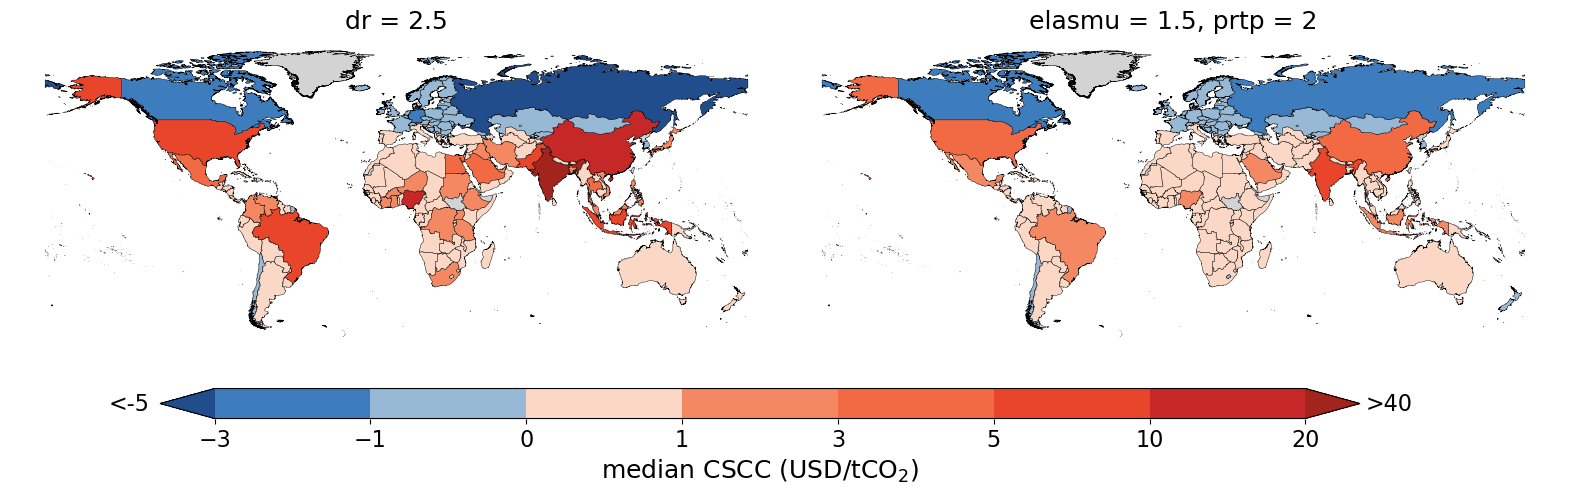

In [159]:
# Load country shapefile
world = gpd.read_file(rawDir + "ne_10m_admin_0_countries.shp")
world = world[world["ADM0_A3"] != "ATA"]

# Binning and color settings
bins = [-3, -1, 0, 1, 3, 5, 10, 20]
colors = [
    "#3d7cbd", "#97b9d6", "#fbd7c6", "#f38863",
    "#f26a44", "#e8452b", "#ce211a", "#c62828",
]
cmap = mpl.colors.ListedColormap(colors).with_extremes(under="#214d8d", over="#a3241d")
norm = mpl.colors.BoundaryNorm(bins, cmap.N)

# Load data
df1 = df_final  # From existing variable
df2 = df_final_ela_prt

# Plotting function
def plot_flux_map_discrete(world, df, column, ax):
    choropleth_df = world.merge(df[["iso", column]], left_on="ADM0_A3", right_on="iso", how="left")
    choropleth_df["bin"] = pd.cut(choropleth_df[column], bins=bins)
    choropleth_df.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,
        edgecolor="black",
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        norm=norm
    )
    ax.set_axis_off()

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.005)  # Reduce horizontal space between maps

# Plot maps
plot_flux_map_discrete(world, df1, "CSCC_median", axes[0])
axes[0].set_title("dr = 2.5", fontsize=18)

plot_flux_map_discrete(world, df2, "CSCC_median", axes[1])
axes[1].set_title("elasmu = 1.5, prtp = 2", fontsize=18)

# Add shared colorbar
cbar_ax = fig.add_axes([0.2, 0.27, 0.6, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    extend="both"
)

cbar.set_label(r"median CSCC (USD/tCO$_2$)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Colorbar min/max labels (can be updated accordingly)
cbar_ax.text(-0.06, 0.5, "<-5", va='center', ha='right', transform=cbar_ax.transAxes, fontsize=16)
cbar_ax.text(1.055, 0.5, ">40", va='center', ha='left', transform=cbar_ax.transAxes, fontsize=16)

# Save and show
plt.savefig(imgDir + "combined_flux_maps.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()


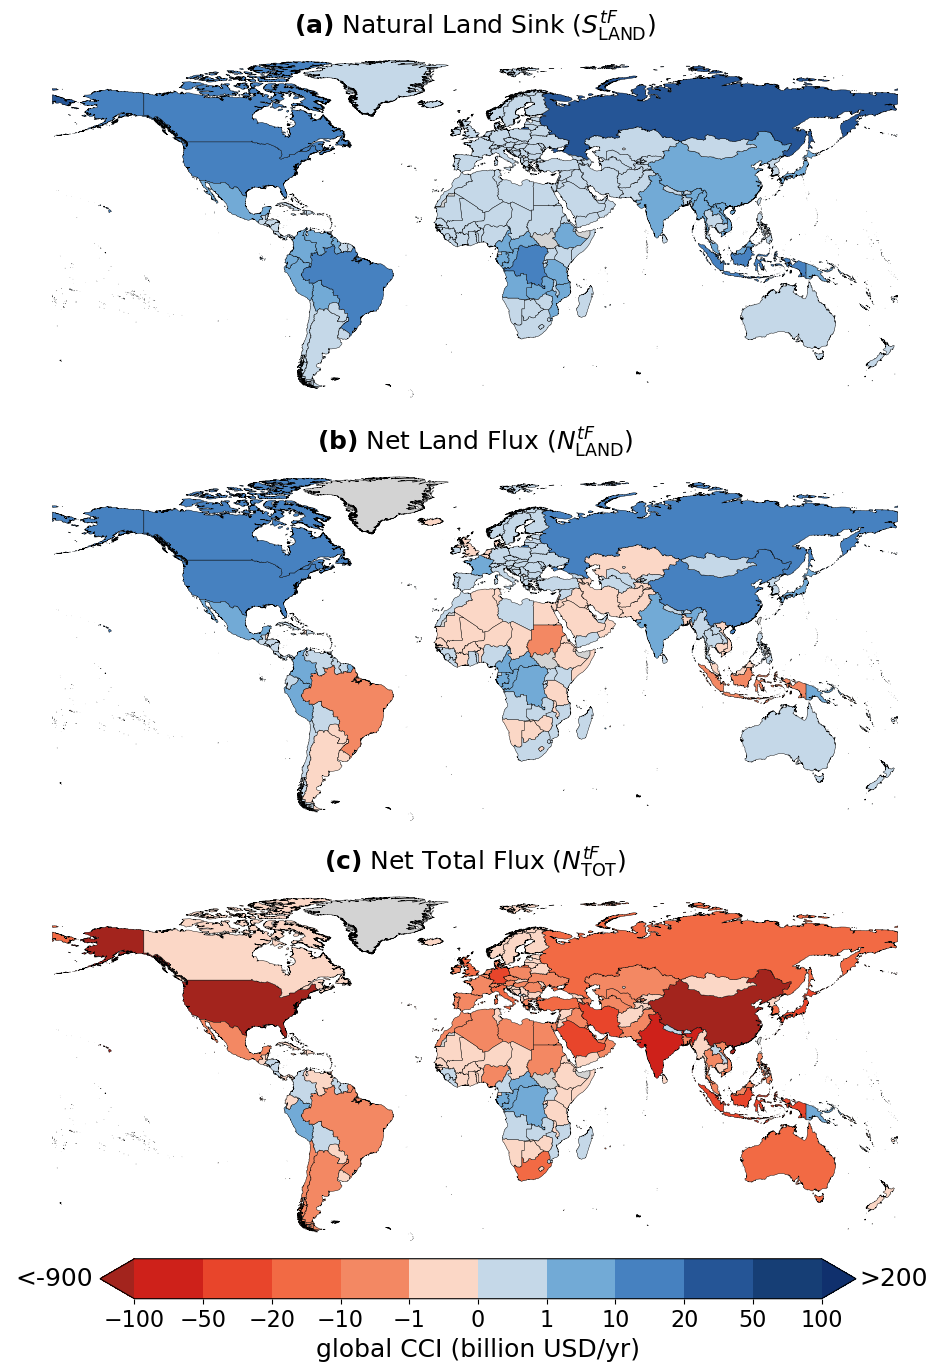

In [160]:
# Define bins and corresponding colors
bins = [-100, -50, -20, -10, -1, 0, 1, 10, 20, 50, 100]

colors = [
    "#ce211a",  # Orange
    "#e8452b",  # Light orange
    "#f26a44",  # Neutral yellow (center ~0)
    "#f38863",  # Pale yellow-green
    "#fbd7c6",  # Light green

    "#c5d8e8",  # Very pale blue-gray
    "#72aad6",  # Light blue
    "#4681c0",  # Medium blue
    "#255596",  # Dark blue
    "#163e75",  # Very dark blue (suggested)
]

# Create a colormap and normalize it to the bins
cmap = mpl.colors.ListedColormap(colors).with_extremes(under="#a3241d", over="#10306d") 
norm = mpl.colors.BoundaryNorm(bins, cmap.N)

# Plotting function
def plot_flux_map_discrete(column, title, ax):
    choropleth_df = world.merge(
        df_final_ela_prt[["iso", column]], left_on="ADM0_A3", right_on="iso", how="left"
    )
    choropleth_df["bin"] = pd.cut(choropleth_df[column], bins=bins)  # Bin the data
    choropleth_df.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,  # Thicker lines for clearer borders
        edgecolor="black",  # Country borders in black
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        norm=norm,  # Use the discrete normalization
    )
    ax.set_title(title, fontsize=18)
    ax.set_axis_off()


# Create subplots for three maps
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

plt.subplots_adjust(hspace=-0.4)  # Reduce vertical space between plots

# Plot each map using discrete colors
plot_flux_map_discrete("FaWglob_tf_median", r"$\bf{(a)}$ Natural Land Sink ($S^{tF}_\mathrm{LAND}$)", axes[0])
plot_flux_map_discrete("FabWglob_tf_median", r"$\bf{(b)}$ Net Land Flux ($N^{tF}_\mathrm{LAND}$)", axes[1])
plot_flux_map_discrete("FabcWglob_tf_median", r"$\bf{(c)}$ Net Total Flux ($N^{tF}_\mathrm{TOT}$)", axes[2])


# Add a color bar with discrete ticks
cbar_ax = fig.add_axes([0.2, 0.17, 0.63, 0.02])  # [left, bottom, width, height]
#cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.02])  # Adjust the position and size

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    extend="both",
)

# Filter out "Total" row
filtered_df = df_final_ela_prt[df_final_ela_prt["iso"] != "Total"]


vmin_label = r"<-900"
vmax_label = r">200"
# Force all bin edges as ticks on the colorbar
cbar.set_ticks(bins)

# Add text annotations next to the colorbar
cbar_ax.text(-0.06, 0.5, vmin_label, va='center', ha='right', transform=cbar_ax.transAxes, fontsize=18)
cbar_ax.text(1.055, 0.5, vmax_label, va='center', ha='left', transform=cbar_ax.transAxes, fontsize=18)

cbar.set_label("global CCI (billion USD/yr)", fontsize=18)  # Adjust label font size
cbar.ax.tick_params(labelsize=16)  # Adjust tick label font size

# Save the plots
plt.savefig(imgDir + "figure_3_ela_prt.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()

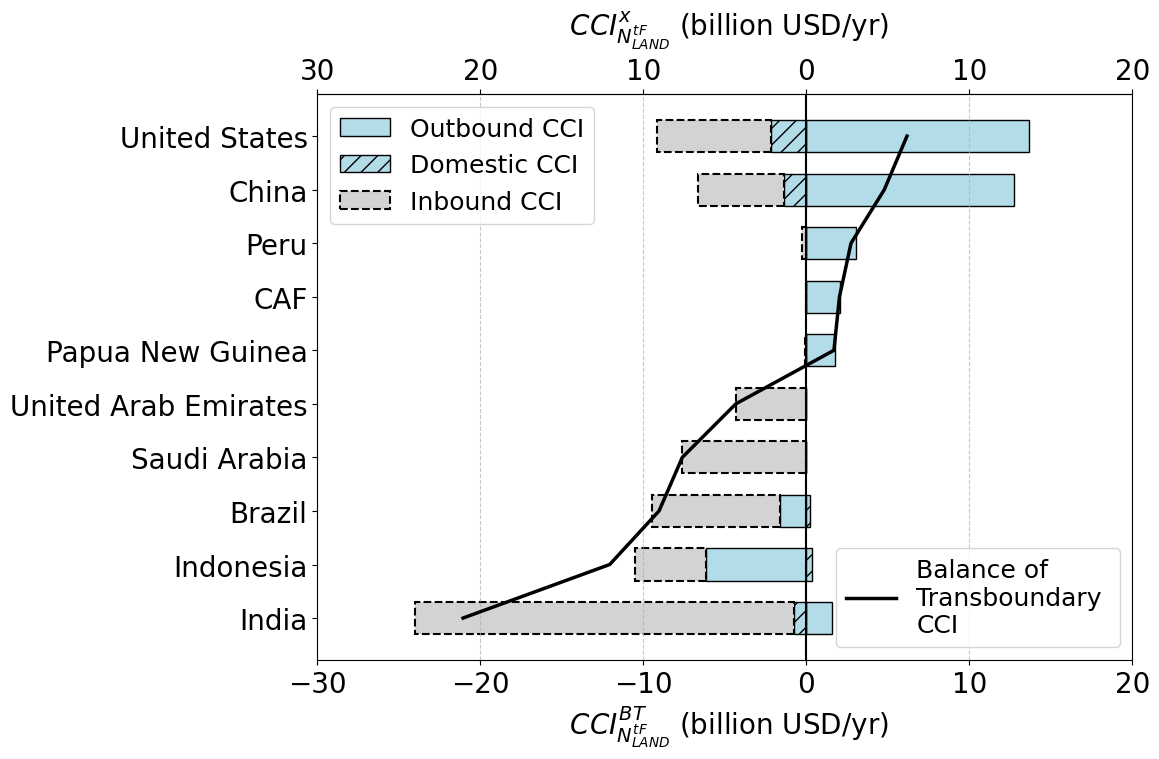

In [161]:
# Filter rows where CSCC_median > 0
df_filtered = df_final_ela_prt[df_final_ela_prt["CSCC_median"] > 0]

# Keep only the 'iso', 'Country', and columns containing 'Fab'
fab_columns = [
    col for col in df_filtered.columns
    if (col.startswith("Fab_") or col.startswith("FabW")) and col.endswith("_median")
]
columns_to_keep = ["iso", "Country"] + fab_columns

# Subset the dataframe
df_fab_positive_cscc = df_filtered[columns_to_keep].sort_values(by="FabWnet_tf_median", ascending=False)

# Get top 5 and bottom 5 (excluding NaNs if any)
top5 = df_fab_positive_cscc.dropna(subset=["FabWnet_tf_median"]).head(5)
bottom5 = df_fab_positive_cscc.dropna(subset=["FabWnet_tf_median"]).tail(5)

# Combine them
df_top_bottom_fabwnet = pd.concat([top5, bottom5])

# Optional: reset index for clean display
df_top_bottom_fabwnet = df_top_bottom_fabwnet.sort_values(by="FabWnet_tf_median", ascending=True).reset_index(drop=True)

# Update country names for specific ISO codes
df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "USA", "Country"] = "United States"
df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "CAF", "Country"] = "CAF"
#df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "PNG", "Country"] = "PNG"

# Extract data
countries = df_top_bottom_fabwnet["Country"]
fabwdom = df_top_bottom_fabwnet["FabWdom_tf_median"] * -1 # Invert sign for plotting
fabwin = df_top_bottom_fabwnet["FabWin_tf_median"] * -1 # Invert sign for plotting
fabwout = df_top_bottom_fabwnet["FabWout_tf_median"]
total = df_top_bottom_fabwnet["FabWnet_tf_median"]


# Setup plot
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(12, 8))
bar_height = 0.6
y = np.arange(len(countries))

# Stack trackers
pos_stack = np.zeros(len(countries))
neg_stack = np.zeros(len(countries))

# Colors and styles
shared_color = "#b3dce9"

# Plot FabWout
for i in range(len(countries)):
    value = fabwout.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color=shared_color, edgecolor = "black", left=base,
            label="Outbound CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value
        
# Plot FabWdom
for i in range(len(countries)):
    value = fabwdom.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color=shared_color, edgecolor="black", hatch="//", left=base,
            label="Domestic CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value

# Plot FabWin
for i in range(len(countries)):
    value = fabwin.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color = "#d3d3d3", edgecolor="black", linestyle= "--", linewidth=1.5, left=base,
            label="Inbound CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value

# Add total line
ax.plot(total, y, color="black", linewidth=2.5, linestyle="-", label="Balance of\nTransboundary \nCCI")


# Formatting
ax.set_yticks(y)
ax.set_yticklabels(countries)
ax.set_xlabel(r" $CCI^{BT}_{N^{tF}_{LAND}}$ (billion USD/yr)")
ax.axvline(0, color="black", linestyle="-", linewidth=1.5)
ax.set_xlim(-30, 20)
# Add mirrored top x-axis
secax = ax.secondary_xaxis("top")

# Match tick locations
secax.set_xticks(ax.get_xticks())

# Set custom labels: here, absolute values
labels = [str(abs(int(t))) for t in ax.get_xticks()]
secax.set_xticklabels(labels)

# Optional: add label
secax.set_xlabel(r" $CCI^x_{N^{tF}_{LAND}}$ (billion USD/yr)", labelpad=15)

#ax.legend(loc="lower right")
#ax.legend(loc="best")

# Get handles and labels from current plot
handles, labels = ax.get_legend_handles_labels()

# Separate them by label name
handles_top = [h for h, l in zip(handles, labels) if "Outbound" in l or "Domestic" in l or "Inbound" in l]
labels_top = [l for l in labels if "Outbound" in l or "Domestic" in l or "Inbound" in l]

handles_bottom = [h for h, l in zip(handles, labels) if "Balance" in l]
labels_bottom = [l for l in labels if "Balance" in l]

# Top left legend: CCI components
legend_top = ax.legend(handles_top, labels_top, loc="upper left", fontsize=18, frameon=True)

# Add it manually to keep the second one from replacing it
ax.add_artist(legend_top)

# Bottom right legend: Balance only
ax.legend(handles_bottom, labels_bottom, loc="lower right", fontsize=18, frameon=True)


# Grid
ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig(imgDir + "figure_4_ela_prt.jpg", dpi=300)
plt.show()

# 4. Per capita

In [186]:
# Import population data from Excel
population_data = pd.read_excel(rawDir + "Worldbank_Population.xlsx")
df_population = population_data[["iso", "population"]].copy().reset_index(drop=True)

# Convert population to numeric (coerce errors to NaN if needed)
df_population["population"] = pd.to_numeric(df_population["population"], errors='coerce')

top10_wealth = df_final.loc[df_final["iso"] != "Total", ["iso", "FabWout_tf_median"]].copy()
top10_wealth = top10_wealth.sort_values("FabWout_tf_median", ascending=False).head(10)

# Merge on ISO
top10_wealth = top10_wealth.merge(df_population, on="iso", how=
                                  "left")

# Calculate wealth per capita (in USD per person)
top10_wealth["wealth_per_capita"] = top10_wealth["FabWout_tf_median"] * 1e9 / top10_wealth["population"]

# Add country names using your iso_mapping dictionary
top10_wealth["Country"] = top10_wealth["iso"].map(country_mapping)
# Update country names for specific ISO codes
top10_wealth.loc[top10_wealth["iso"] == "USA", "Country"] = "United States"
top10_wealth.loc[top10_wealth["iso"] == "COD", "Country"] = "DR Congo"
top10_wealth.loc[top10_wealth["iso"] == "CAF", "Country"] = "CAF"
top10_wealth.loc[top10_wealth["iso"] == "PNG", "Country"] = "PNG"

print(top10_wealth)

   iso  FabWout_tf_median    population  wealth_per_capita        Country
0  RUS         105.936748  1.452451e+08         729.365140         Russia
1  USA          87.313853  3.315269e+08         263.368807  United States
2  CHN          72.774312  1.411100e+09          51.572753          China
3  CAN          68.159466  3.802864e+07        1792.319407         Canada
4  PER          18.167023  3.283858e+07         553.221958           Peru
5  CAF          12.301546  5.026628e+06        2447.276050            CAF
6  MEX          11.556639  1.267991e+08          91.141367         Mexico
7  COL          11.398953  5.063000e+07         225.142286       Colombia
8  PNG          10.038687  9.815746e+06        1022.712600            PNG
9  COD           9.304514  9.599000e+07          96.932122       DR Congo


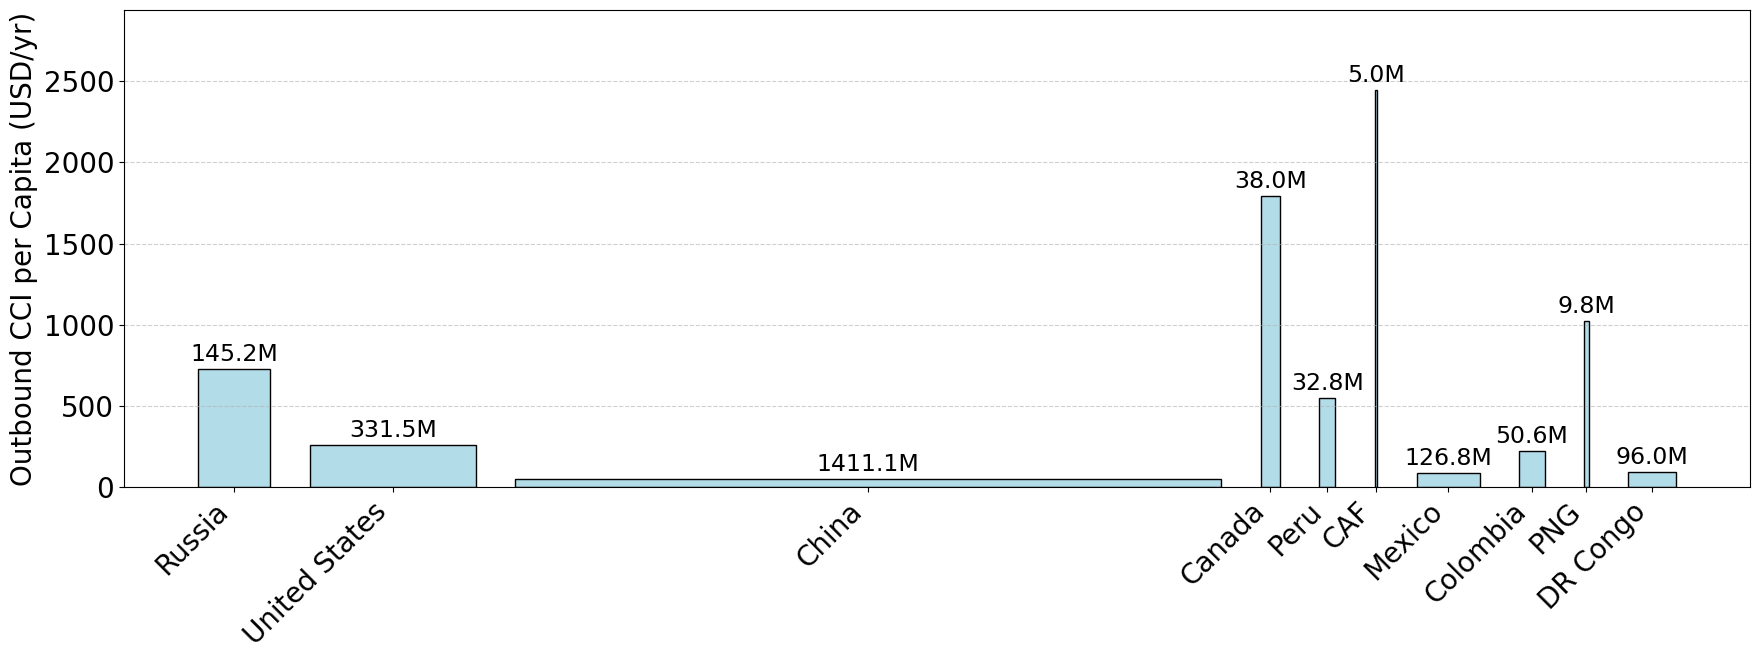

In [187]:
# Sort for visual consistency
top10_wealth = top10_wealth.sort_values("FabWout_tf_median", ascending=False).reset_index(drop=True)

# Data
countries = top10_wealth["Country"]
wealth_per_capita = top10_wealth["wealth_per_capita"]
population = top10_wealth["population"]

# Normalize population to define bar widths
max_width = 0.9  # maximum width (in axis units)
normalized_width = population / population.max() * max_width

# Define x positions with gaps
gap = 0.05
x_positions = np.cumsum(np.insert(normalized_width[:-1] + gap, 0, 0))  # start positions of each bar
x_centers = x_positions + normalized_width / 2  # center positions for plotting and labeling

# Plot
plt.figure(figsize=(18, 7))
bars = plt.bar(x_centers, wealth_per_capita, width=normalized_width, edgecolor='black', align='center', color="#b3dce9")

# Add population annotations (rounded to millions)
for i, (x, wpc, pop) in enumerate(zip(x_centers, wealth_per_capita, population)):
    plt.text(x, wpc + max(wealth_per_capita)*0.02, f'{pop/1e6:.1f}M', ha='center', fontsize=17)

# define y-axis limits
plt.ylim(0, max(wealth_per_capita) * 1.2)
# Set x-axis labels at center positions
plt.xticks(x_centers, countries, rotation=45, ha='right')

# Labels and title
#plt.xlabel("Country ISO Code (Bar Width = Population Size)")

plt.ylabel("Outbound CCI per Capita (USD/yr)")
#plt.title("Top 10 Countries by Wealth per Capita\n(Bar Width = Population, Labels Show Population)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig(imgDir + "figure_10_SI.jpg", format="jpg")
plt.show()
